In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import pandas as pd
# Pour torch si vous avez un GPU
device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU

In [2]:
from environnement.environnement import Environnement as env # mother class
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld

# model machine learning
from model.Tokenizer import *
from model.RNN import *
from model.CustomDataSet import CustomDataSet, CustomDataSetRNN
from outil import *
from inter.simpleInteraction import simpleInteraction as inter

# L'agent :
L'idée de se fichier est de mettre en place une exploration guidé. Le principe est de repérer les séquences pour lequel le model de prédicition n'est pas sûr, et de choisir celle qui aurait la meilleur valence. Cette idée ne peut fonctionner que si les séquences sont déterministe.

In [3]:
class AgentLSTM:
    def __init__(self, valence:dict[inter], model:nn.Module, maxDepth:int,
                 seuil:float, optimizer, loss_fn, gap:int=11, nb_epochs:int=50, 
                 data_val:tuple=None, device="cpu"):
        """
        Create an agent with a LSTM model and spesific decision making.
        data_val is composed by list of all actions and outcomes. And 
        is not useful to train the model. It's just to have a monitoring
        of the model. \n
        valence: dict of interactions, is use to know what is a good 
        comportment \n
        model: the model to train, this agent was create for LSTM model 
        \n
        
        """
        self.model:nn.Module = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.valence:dict[inter] = valence
        self.maxDepth:int = maxDepth
        self.seuil:float = seuil
        self.gap:int = gap
        self.nbEpochs:int = nb_epochs
        self.force_fit:bool = False
        self.device = device
        self.last_train = 0
        self.proba = 0
        
        self.seq_to_exe = [] # Sequence choice by Decide
        self.seq_exe = []
        self.compute_seq = {}
        self.history_act = [] # History of all actions
        self.history_fb = [] # History of all feedback
        self.history_inter = [] # History of all interactions
        
        self.all_outcomes = set()
        self.all_act = set()
        key:inter = None
        for key in valence.keys():
            self.all_outcomes.add(key.getOutcome())
            self.all_act.add(key.getAction())
            
        self.all_outcomes = list(self.all_outcomes)
        self.all_act = list(self.all_act)
        
        self.tokenizer = SimpleTokenizerV1(
            vocab={key: i for i, key in enumerate(self.all_outcomes + self.all_act)})
        
        self.seq_explo = []
        self.valence_explo = -np.inf
        
        self.action_choice = self.all_act[0] # Default action, because developpemental start with action
        self.history_act.append(self.action_choice)
        self.outcome_prediction = None
        
        self.memory = {}
        
        # Variable to monitor the model
        self.loss_train:list = []
        self.acc_train:list = []
        self.loss_test:list = [0]
        self.acc_test:list = []
        self.time_train:list = []
        self.time_expected_val:list = []
        self.time_train:list = []
        self.time_expected_val:list = []
        self.predictExplor:list = []
        if data_val is not None:
            dataset_test = CustomDataSetRNN(actions=data_val[0], outcomes=data_val[1], context_lenght=self.gap, 
                                    dim_out=len(self.all_outcomes), tokenizer=self.tokenizer)
            self.data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
        else:
            self.data_loader_test = None
        number_patern = 2000000
        self.prealloc_df = pd.DataFrame(np.empty((number_patern, 5)), 
                                    columns=["proposition", "valence", "action", "probability", "val_sucess"])
        self.prealloc_df = self.prealloc_df.astype({"proposition": "U20", "valence": float, "action": "U20", "probability": float, "val_sucess": float})
        
        self.current_index = 0
        self.visu_explo = pd.DataFrame(np.empty((number_patern, 2)), columns=["seqence", "valence"])
        self.visu_explo = self.visu_explo.astype({"seqence": "U20", "valence": float})
        self.current_index_explo = 0
        
        if data_val is not None:
            self.visu_val = pd.DataFrame(np.empty((len(data_val[0]), 3)), 
                                        columns=["seqence", "probablility", "good"])
            self.visu_val = self.visu_val.astype({"seqence": "U20", "probablility": float, "good": bool})
            self.current_index_val = 0
        
    def fit(self):
        """
        train model
        """
        dataset = CustomDataSetRNN(actions=self.history_act, outcomes=self.history_fb, 
                                 context_lenght=self.gap, dim_out=len(self.all_outcomes),
                                 tokenizer=self.tokenizer)
        
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

        time_train = time.time()
        
        for i in range(self.nbEpochs):
            self.model.train()
            steps = 0
            train_acc = 0
            training_loss = []
            for tmp, (x,t) in enumerate(data_loader):
                x = x.to(self.device)
                t = t.to(self.device)
                bs = t.shape[0]
                h = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)
                cell = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)

                pred, h, cell = self.model(x, h, cell)

                loss = self.loss_fn(pred[:, -1, :], t)
                training_loss.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_acc += sum((pred[:, -1, :].argmax(1) == t).cpu().numpy())
                steps += bs
            
            self.acc_train.append(train_acc / steps)
            if self.data_loader_test is not None:
                self.model.eval()
                steps = 0
                test_acc = 0
                loss_test = []
                
                for text, label in self.data_loader_test:
                    text = text.to(self.device)
                    label = label.to(self.device)
                    bs = label.shape[0]

                    # Initialize hidden and memory states
                    hidden = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)
                    memory = torch.zeros(self.model.num_layers, bs, self.model.hidden_size, device=self.device)
                    
                    # Forward pass through the model
                    pred, hidden, memory = self.model(text, hidden, memory)
                    
                    for i in range(bs):
                        self.visu_val.iloc[steps + i] = [str(self.tokenizer.decode(text[i].cpu().tolist())), 
                                                         float(torch.nn.functional.softmax(pred[i, -1, :], dim=-1).max().item()), 
                                                         int(pred[i, -1, :].argmax().item() == label[i])]

                    # Calculate the loss
                    loss = self.loss_fn(pred[:, -1, :], label)
                    loss_test.append(loss.item())

                    # Calculate test accuracy
                    test_acc +=  sum((pred[:, -1, :].argmax(1) == label).cpu().numpy())
                    steps += bs
                    
                loss_test.append(loss_test)
                self.acc_test.append(test_acc / steps)
                # print(f"Validation time: {time.time() - time_val_epoch}")    
            self.loss_train.append(training_loss)
            # If acc is 100% we stop the training
            if self.acc_train[-1] >= 0.99:
                for _ in range(i, self.nbEpochs):
                    self.acc_train.append(self.acc_train[-1])
                    if self.data_loader_test is not None:
                        self.loss_test.append(self.loss_test[-1])
                break
            
        print(f"Training time: {time.time() - time_train}")
        self.time_train.append(time.time() - time_train)
        
    def predict(self, action):
        """
        Predict the feedback of the action, use the last gap actions/outcomes
        """        
        x = []
        for i in range(-(self.gap - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        x.append(action)
        seq_to_pred = self.tokenizer.encode(x)
        # On simule un batch de taille 1
        seq_to_pred = torch.tensor([seq_to_pred], device=self.device)
        h = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=self.device)
        cell = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=self.device)
        probs, _, _ = self.model(seq_to_pred, h, cell)
        
        pred_feedback = torch.argmax(probs[:, -1, :]).item()
        pred_feedback = self.tokenizer.decode(pred_feedback)
        
        return pred_feedback      
            
    def verify_explo(self, seq_to_pred, action, max_depth:int):
        sub_list = subfinder(self.history_inter, seq_to_pred[-3:])        
        dict_explo = None
        if sub_list == []:
            best_inter, value = max(self.valence.items(), key=lambda y: y[1])
            proba = [0] * len(self.all_outcomes)
            proba[self.all_outcomes.index(best_inter.getOutcome())] = 1
            sequel = {
                "action" : best_inter.getAction(),
                "expected_valence" : value,
                "outcome" : {},
                # "outcome" : {"proba": proba, best_inter.getOutcome() : {}},
            }
            other_outcome = [out for out in self.all_outcomes if out != best_inter.getOutcome()]
            inter_with_act = [inter(action, out) for out in self.all_outcomes]
            best_inter = None
            tmp_valence = -np.inf
            for tmp_inter in inter_with_act:
                if self.valence[tmp_inter] > tmp_valence:
                    best_inter = tmp_inter
                    tmp_valence = self.valence[tmp_inter] 
            proba = [0] * len(self.all_outcomes)
            proba[self.all_outcomes.index(best_inter.getOutcome())] = 1
            dict_explo = {
                "action" : action,
                "expected_valence" : tmp_valence + sequel["expected_valence"],
                "outcome" : {"proba": proba, best_inter.getOutcome() : sequel},
            }
            for out in other_outcome:
                dict_explo["outcome"].update({
                    out : {}
                })
            
            
        return dict_explo
    
    def recursif_expective_valance(self, context:list, max_depth:int, seuil:float=0.5, proba:float = 1,
                                   seq_predi:list = [], valence_pred:float = 0, valence_succes_pred:float = 0):
        """
        Create the list of proposed sequences
        """
        max_depth -= 1
        self.model.eval()
        # Compute the expected valence of each action
        list_action = []
        for act in self.all_act:
            dict_seq = {
                    "action" : act,
                    "expected_valence" :0,
                }
            new_seq = seq_predi + [act]
            seq_to_predict = context + [self.tokenizer.encode(act)]
            explo = self.verify_explo(seq_to_predict[-3:], act, max_depth)
            if explo is not None:
                list_action.append(explo)
                continue
            
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.int).to(device)
            hidden = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
            memory = torch.zeros(self.model.num_layers, 1, self.model.hidden_size, device=device)
            x, _, _ = self.model(seq_to_predict, hidden, memory)
            x = x[0, -1, :]
            probs = torch.nn.functional.softmax(x, dim=0).tolist()
            dict_seq["outcome"] = {"proba": probs}
            for i, out in enumerate(self.all_outcomes):
                visu_val = None
                tmp_new_seq = new_seq + [out]
                tmp_proba = probs[i] * proba
                
                if tmp_proba > seuil:
                    if max_depth > 0:
                        new_context = context + self.tokenizer.encode([act, out])
                        children = self.recursif_expective_valance(context=new_context[2:], max_depth=max_depth, seuil=seuil, 
                            proba=tmp_proba, seq_predi=tmp_new_seq.copy(), valence_pred=None, valence_succes_pred=None)
                    
                        best_child = max(children, key=lambda x: x["expected_valence"])
                        dict_seq["outcome"].update({
                            out : best_child,
                        })
                        dict_seq["expected_valence"] += best_child["expected_valence"] * probs[i] + self.valence[inter(act, out)] * probs[i]
                    else:
                        dict_seq["outcome"].update({
                            out : {}
                        })
                        dict_seq["expected_valence"] += self.valence[inter(act, out)] * probs[i]
                else:
                    dict_seq["outcome"].update({
                        out : {}
                    })
                    dict_seq["expected_valence"] += self.valence[inter(act, out)] * probs[i]
                        
            list_action.append(dict_seq)
                    # else:
                    #     dict_inter = {
                    #         "inter": inter(act, out),
                    #         "expected_validation": self.valence[inter(act, out)] * probs[i],
                    #         "children" : [],
                    #     }

                   
        return list_action

    
    def expective_valance(self):
        """
        Permet de calculer l'expective valance d'une séquence d'interaction

        Args:
            max_depth (int): _description_
            seuil (float, optional): _description_. Defaults to 0.2.
            verbose (bool, optional): _description_. Defaults to False.
        """
        
        x = []
        for i in range(-(self.gap - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        seq_to_pred = self.tokenizer.encode(x)
        # self.prealloc_df[:] = np.empty((len(self.prealloc_df), 5))
        # self.prealloc_df["valence"] = -np.inf
        # self.current_index = 0
        # self.seq_explo = []
        # self.valence_explo = -np.inf
        # self.visu_explo[:] = np.empty((len(self.visu_explo), 2))
        # self.current_index_explo = 0
        if str(x) in self.memory.keys():
            if self.memory[str(x)] ["iteraction_update"] >= self.last_fit:
                print("i use memory")
                print(self.memory[str(x)] ["prealloc_df"])
                self.compute_seq = self.memory[str(x)] ["prealloc_df"]
                return
    
        tmp = self.recursif_expective_valance(context=seq_to_pred,
                            max_depth=self.maxDepth,
                            proba=1, seq_predi=[],
                            seuil=self.seuil)
        self.compute_seq = max(tmp, key=lambda x: x["expected_valence"])
        self.memory[str(x)] = {
            "prealloc_df" : self.compute_seq,
            "iteraction_update" : len(self.history_act)
        }
        
    def decide(self):
        """
        Permet de choisir une action en fonction de l'expective valance prédite
        """
        if self.compute_seq != {}:
            # print("i follow : \n", self.compute_seq)
            self.compute_seq = self.compute_seq[self.history_fb[-1]]
            if self.compute_seq == {}:
                # self.force_fit = True
                time_compute_expective_val = time.time()
                self.expective_valance()
                print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
                self.time_expected_val.append(time.time() - time_compute_expective_val)
            else :
                print("act choice")
        else :
            time_compute_expective_val = time.time()
            self.expective_valance()
            print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
            self.time_expected_val.append(time.time() - time_compute_expective_val)

        if self.compute_seq == []:
            print("i have no compute seq")
        print(f"expected valence : {self.compute_seq['expected_valence']:.2f} model predict : {self.compute_seq}")
        action = self.compute_seq["action"]

        self.compute_seq = self.compute_seq["outcome"]
        return action
        
    def action(self, real_outcome, verbose=False):
        """
        La fonction action permet à l'agent de choisir une action en fonction de l'outcome réel.
        Cette fonction entraine le modèle a prévoir les outcomes futurs en fonction des actions passées.

        Args:
            real_outcome : L'outcome réel suite à l'action de l'agent
            verbose : Affiche les informations sur l'entrainement ou non
        """
        # La première étape est de sauvegarder l'outcome réel
        self.history_fb.append(real_outcome)
        self.history_inter.append(self.tokenizer.encode(real_outcome))
        good_pred:bool = self.outcome_prediction == real_outcome
        if verbose :
            print(f"\033[0;31m Action: {self.action_choice} \033[0m, Prediction: {self.outcome_prediction}, Outcome: {real_outcome}, \033[0;31m Satisfaction: {good_pred} \033[0m")
        
        # Ensuite nous regardons si nous devons entrainer le modèle
        # not(explore) and 
        if (not(good_pred) or self.force_fit) and (len(self.history_fb) + len(self.history_fb) > self.gap) and (self.proba > 0.6 or self.proba < 0.4):
            print("fit because probability is ", self.proba)
            self.fit()
            self.last_fit = len(self.history_act)
            self.force_fit = False
            
        elif len(self.history_fb) + len(self.history_fb) > self.gap:
            for _ in range(self.nbEpochs):
                self.acc_train.append(self.acc_train[-1])
                if self.data_loader_test is not None:
                    self.loss_test.append(self.loss_test[-1])

        # Nous devons maintenant choisir une action
        if len(self.history_fb) + len(self.history_fb) > self.gap:
            self.action_choice = self.decide()
            self.outcome_prediction = self.predict(self.action_choice)
        else:
            inter_max, value = max(self.valence.items(), key=lambda y: y[1])
            self.action_choice = inter_max.getAction()
        # self.action_choice = np.random.choice(self.all_act)
        self.history_act.append(self.action_choice)
        self.history_inter.append(self.tokenizer.encode(self.action_choice))
        
        return self.action_choice, self.outcome_prediction
        
              

In [4]:
# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 0, 1, 0, 1],
#                 [1, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1],
#             ]))

# environenment = small_loop(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1, 1],
#                 [1, 0, 1, 0, 0, 1],
#                 [1, 0, 1, 1, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

environenment = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

environenment = small_loop(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

valence = {
    inter('forward', 'empty') : 10,
    inter('forward', 'wall') : -100,
    inter('turn_left', 'empty') : -20,
    inter('turn_left', 'wall') : -100,
    inter('turn_right', 'empty') : -20,
    inter('turn_right', 'wall') : -100,
    inter('feel_front', 'wall') : -15,
    inter('feel_front', 'empty') : -12,
}

In [5]:
environenment = gridWorld(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
                [1, 0, 1, 1, 1, 0, 0, 1, 0, 1],
                [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                [1, 1, 0, 0, 0, 1, 1, 0, 1, 1],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                
            ]))
# environenment = gridWorld(x=1, y=1, theta=0, world=np.array([
#                 [1, 1, 1, 1, 1, 1],
#                 [1, 0, 0, 0, 1, 1],
#                 [1, 0, 1, 0, 0, 1],
#                 [1, 0, 1, 1, 0, 1],
#                 [1, 0, 0, 0, 0, 1],
#                 [1, 1, 1, 1, 1, 1],
#             ]))

valence = {
    inter('forward', 'empty') : 100,
    inter('forward', 'wall') : -200,
    inter('turn_left', 'empty') : -35,
    inter('turn_left', 'wall') : -100,
    inter('turn_right', 'empty') : -35,
    inter('turn_right', 'wall') : -100,
    inter('feel_front', 'wall') : -20,
    inter('feel_front', 'empty') : -20,
    inter('feel_right', 'wall') : -20,
    inter('feel_right', 'empty') : -20,
    inter('feel_left', 'wall') : -20,
    inter('feel_left', 'empty') : -20   
}

# Pour évaluler la performance du modèle
# act_val, fb_val = [], []
# for i in trange(1000):
#     action = np.random.choice(environenment.get_actions())
#     outcome = environenment.outcome(action)
#     act_val.append(action)
#     fb_val.append(outcome)
    
# data_val = (act_val, fb_val)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1 1 1 1 1]
 [1 0 0 0 1 0 0 0 1 1]
 [1 0 1 0 0 1 1 0 0 1]
 [1 0 1 1 1 0 0 1 0 1]
 [1 0 0 1 0 0 0 0 0 1]
 [1 1 0 0 0 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


In [6]:
# torch.manual_seed(0)
# np.random.seed(0)
hidden_size = 16
num_layers = 1
len_vocab = len(environenment.get_outcomes() + environenment.get_actions())

# Create the LSTM classifier model
lstm_classifier = LSTM_Classifeur(num_emb=len_vocab, output_size=2, 
                       num_layers=num_layers, hidden_size=hidden_size, dropout=0.5).to(device)

optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(environenment.get_outcomes() + environenment.get_actions()))

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [7]:
# Pour évaluler la performance du modèle
# act_val, fb_val = [], []
# for i in trange(1000):
#     action = np.random.choice(environenment.get_actions())
#     outcome = environenment.outcome(action)
#     act_val.append(action)
#     fb_val.append(outcome)

# Init model

In [8]:
agent = AgentLSTM(valence=valence, model=lstm_classifier, optimizer=optimizer, loss_fn=loss_func,
    data_val=None, device=device, gap=5, nb_epochs=50, maxDepth=5, seuil=0.2)

In [9]:
history_good = []
history_good_inter = []
history_bad_inter = []
hisrory_val = []
pourcent_by_10  = []
by_10_good_inter  = []
by_10_bad_inter  = []
mean_val = []


In [10]:
# torch.manual_seed(0)
# np.random.seed(0)

outcome = environenment.outcome(agent.action_choice)
environenment.save_world(path="imgToGif3")

print("Start ...")
print(agent.action_choice)
print(outcome)

for i in tqdm(range(500)):
    if i % 50 == 0:
        agent.force_fit = True
    action, predi = agent.action(outcome, verbose=True)
    print(agent.compute_seq)
    df2 = agent.prealloc_df
    df_explo2 = agent.visu_explo
    #  save_evolued_acc(agent.acc_train[-agent.nb_epoch:], path=f"plot3/acc_train_{i}.png")
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world(path="imgToGif3")

agent.prealloc_df.to_csv("prealloc_df.csv")
agent.visu_explo.to_csv("df_explo.csv")

pourcent_by_10 = pourcent_by_10[10:]
by_10_good_inter = by_10_good_inter[10:]
by_10_bad_inter = by_10_bad_inter[10:]
mean_val = mean_val[10:]
raise Exception("End ...")

Start ...
feel_right
empty


  0%|          | 0/500 [00:00<?, ?it/s]

 Action: feel_right , Prediction: None, Outcome: empty,  Satisfaction: False 
{}
 Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
{}
 Action: forward , Prediction: None, Outcome: wall,  Satisfaction: False 
fit because probability is  0
Training time: 0.03819084167480469
Time to compute expective valance: 0.001688241958618164
expected valence : 80.00 model predict : {'action': 'feel_right', 'expected_valence': 80, 'outcome': {'proba': [1, 0], 'wall': {}}}
{'proba': [1, 0], 'wall': {}}
 Action: feel_right , Prediction: wall, Outcome: empty,  Satisfaction: False 
fit because probability is  0
Training time: 0.009373903274536133


KeyError: 'empty'

In [ ]:
for i in tqdm(range(400)):
    if i % 30 == 0:
        agent.force_fit = True
    action, predi = agent.action(outcome, verbose=True)
    df2 = agent.prealloc_df
    df_explo2 = agent.visu_explo
    outcome = environenment.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environenment.save_world("imgToGif3")

  0%|          | 0/400 [00:00<?, ?it/s]

 Action: feel_right , Prediction: wall, Outcome: wall,  Satisfaction: True 
fit because probability is  0
Training time: 2.051130533218384
act choice
expected valence : -3.76 model predict : {'action': 'feel_front', 'expected_valence': -3.7561544305753145, 'outcome': {'proba': [0.302695095539093, 0.6973048448562622], 'empty': {'action': 'forward', 'expected_valence': 99.73713137442246, 'outcome': {'proba': [0.999123752117157, 0.0008762191864661872], 'empty': {}, 'wall': {}}}, 'wall': {'action': 'feel_front', 'expected_valence': -19.999998903949745, 'outcome': {'proba': [0.00036234143772162497, 0.9996376037597656], 'empty': {}, 'wall': {}}}}}
 Action: feel_front , Prediction: wall, Outcome: wall,  Satisfaction: True 
act choice
expected valence : -20.00 model predict : {'action': 'feel_front', 'expected_valence': -19.999998903949745, 'outcome': {'proba': [0.00036234143772162497, 0.9996376037597656], 'empty': {}, 'wall': {}}}
 Action: feel_front , Prediction: wall, Outcome: wall,  Satisf

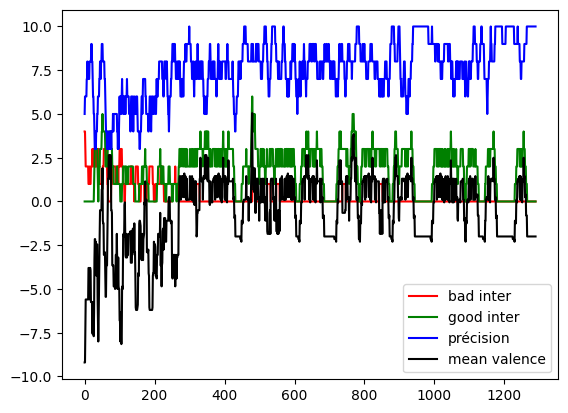

In [ ]:
# Function to map integers to colors
def int_to_color(value):
    if value == 0:
        return "yellow"
    return "gray"

# Create a figure and axis
fig, ax = plt.subplots()

#1 / (len(by_10_bad_inter) -10)
for i, value in enumerate(agent.predictExplor):
    ax.add_patch(plt.Rectangle((i, -10), 0.1, 10, color=int_to_color(value), alpha=0.4))

# Plot the data
plt.plot(by_10_bad_inter, label='bad inter', color='red')
plt.plot(by_10_good_inter, label='good inter', color='green')
plt.plot(pourcent_by_10, label='précision', color='blue')
plt.plot(mean_val, label='mean valence', color='black')

# Add legend
plt.legend()


# Show the plot
plt.show()

# Close the plot
plt.close()


In [ ]:
see_evolued_loss(agent.loss_train)
see_evolued_acc(agent.acc_train)
see_evolued_acc(agent.acc_test)

see_evolued_acc(agent.time_train)
see_evolued_acc(agent.time_expected_val)




In [ ]:
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as py

# Get weights
embds = agent.model.embedding.weight.detach().cpu().numpy()

# Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step, 0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text = [tokenizer.decode(i) for i in range(start, stop, step)]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

# Visualize words in two dimensions 
# Set perplexity to a value less than the number of samples
perplexity_value = min(30, len(embds) - 1)  # Ensure perplexity is less than the number of samples
conv_tsne_embds = TSNE(n_components=2, perplexity=5).fit_transform(embds)
plot_words(conv_tsne_embds, 0, len(embds), 1)